In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

gdp = pd.read_csv('data/gdp.csv')
inflation = pd.read_csv('data/inflation.csv')
unemployment = pd.read_csv('data/unemployment.csv')
yield_data = pd.read_csv('data/yield.csv') 


### Yield curves

            LongTermRate     Slope
Date                              
1961-06-30      0.160110  0.463769
1961-07-31      0.164034  0.446137
1961-08-31      0.169935  0.452569
1961-09-30      0.165211  0.453090
1961-10-31      0.152620  0.455216


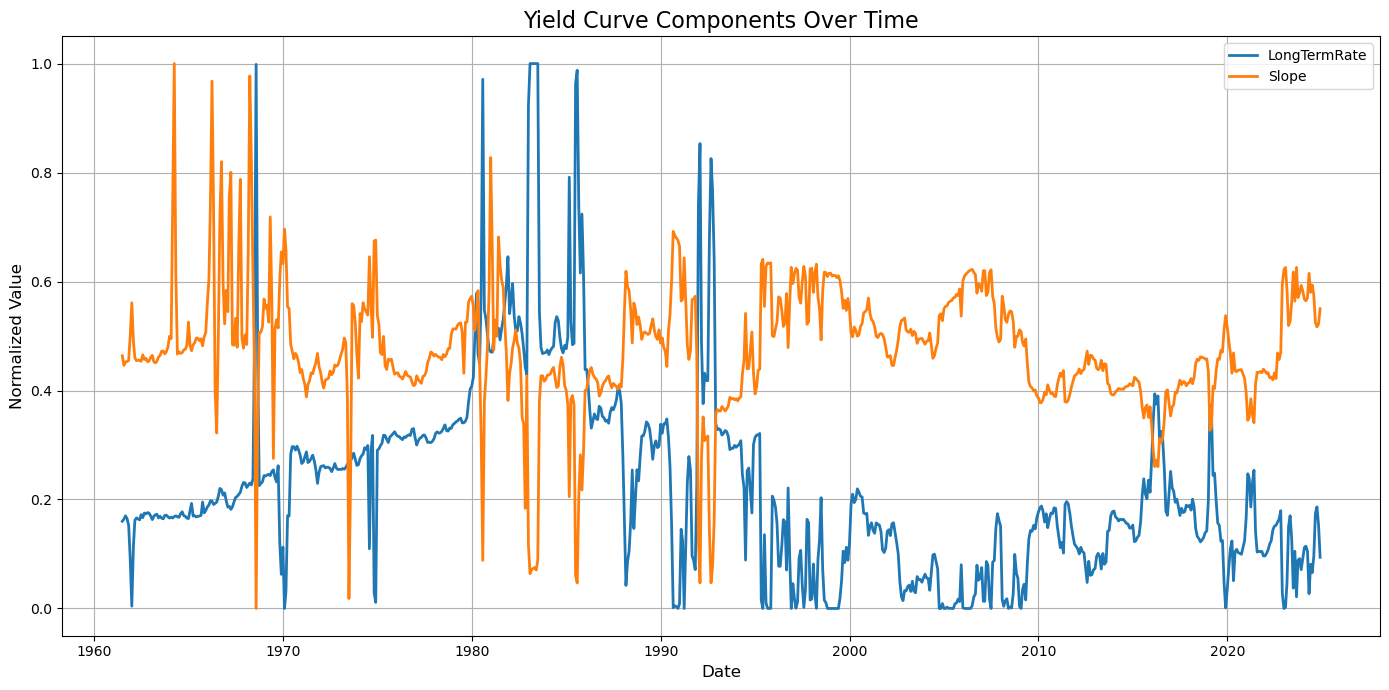

In [107]:
# Convert to datetime
yield_data['Date'] = pd.to_datetime(yield_data['Date'], errors='coerce')

# Replace invalid values with NaN
yield_data.replace(-999.99, pd.NA, inplace=True)

# Drop columns with more than 20% missing values
threshold = 0.2 * len(yield_data)
columns_to_drop = yield_data.columns[yield_data.isnull().sum() > threshold]
yield_data = yield_data.drop(columns=columns_to_drop)

# Rename columns
column_rename_mapping = {
    'BETA0': 'LongTermRate',    # Reflects investor confidence about long-term economic growth and inflation
    'BETA1': 'Slope',           # A negative slope (yield curve inversion) signals a possible recession
}

for i in range(1, 31):
    column_rename_mapping[f'SVENPY{i:02d}'] = f'SpotRate{i}Y'
    column_rename_mapping[f'SVEN1F{i:02d}'] = f'ForwardRate{i}Y'

yield_data.rename(columns=column_rename_mapping, inplace=True)

# Set 'Date' as the index for resampling
yield_data.set_index('Date', inplace=True)

# Resample to monthly frequency
monthly_data = yield_data.resample('M').mean()

# Interpolate missing values for continuous features, including key features
monthly_data_interpolated = monthly_data.interpolate(method='linear', limit_direction='forward', axis=0)

# Normalize continuous features (focus on LongTermRate and Slope)
features_to_normalize = ['LongTermRate', 'Slope']
monthly_data_interpolated[features_to_normalize] = monthly_data_interpolated[features_to_normalize].apply(
    lambda x: (x - x.min()) / (x.max() - x.min()), axis=0
)

# Display the first few rows of the processed dataset
print(monthly_data_interpolated[features_to_normalize].head())

# Plot: Line plot for LongTermRate and Slope
plt.figure(figsize=(14, 7))
plt.plot(monthly_data_interpolated.index, monthly_data_interpolated['LongTermRate'], label='LongTermRate', linewidth=2)
plt.plot(monthly_data_interpolated.index, monthly_data_interpolated['Slope'], label='Slope', linewidth=2)

# Add labels, legend, and title
plt.title('Yield Curve Components Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Unemployment

            overall_rate  men_rate  women_rate  men_16_17_rate  \
date                                                             
1948-01-01      0.073171       3.4         3.3             9.7   
1948-02-01      0.105691       3.6         4.5            13.0   
1948-03-01      0.121951       3.8         4.4            14.0   
1948-04-01      0.113821       3.8         4.3            11.6   
1948-05-01      0.081301       3.5         3.7             7.1   

            women_16_17_rate  men_16_19_rate  women_16_19_rate  \
date                                                             
1948-01-01               8.8             9.4               7.2   
1948-02-01              13.2            10.8               8.9   
1948-03-01              11.4            11.9               8.6   
1948-04-01              10.6             9.8               9.2   
1948-05-01               5.4             7.6               6.1   

            men_18_19_rate  women_18_19_rate  men_16_24_rate  ...  \
date 

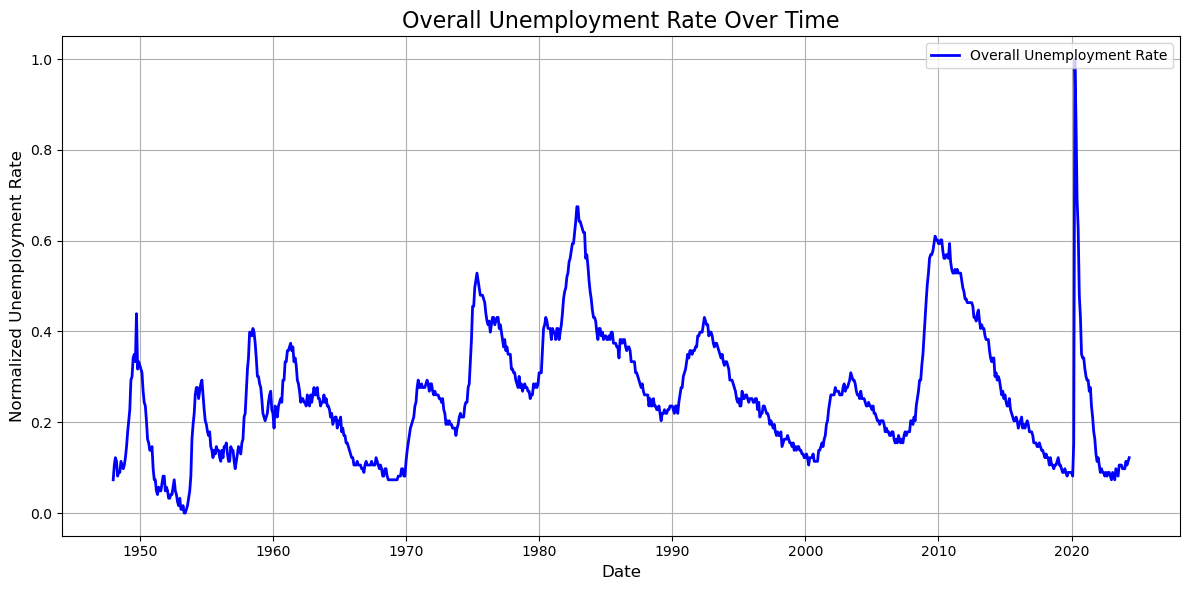

In [108]:
from sklearn.preprocessing import MinMaxScaler

# Convert to datetime
unemployment['date'] = pd.to_datetime(unemployment['date'], errors='coerce')
unemployment.set_index('date', inplace=True)
unemployment.sort_index(inplace=True)

# Find and Fill all missing data while dropping columns that dont meet threshold
threshold = 0.2 * len(unemployment)
columns_to_drop = unemployment.columns[unemployment.isnull().sum() > threshold]
unemployment = unemployment.drop(columns=columns_to_drop)
unemployment.interpolate(method='linear', inplace=True) # use linear interpolation for filling NA values

# Normalize data
scaler = MinMaxScaler()
unemployment['overall_rate'] = scaler.fit_transform(unemployment[['overall_rate']])


print(unemployment.head())

plt.figure(figsize=(12, 6))
plt.plot(unemployment.index, unemployment['overall_rate'], label='Overall Unemployment Rate', linewidth=2, color='blue')

# Adding labels, title, and legend
plt.title('Overall Unemployment Rate Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Unemployment Rate', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


### Inflation

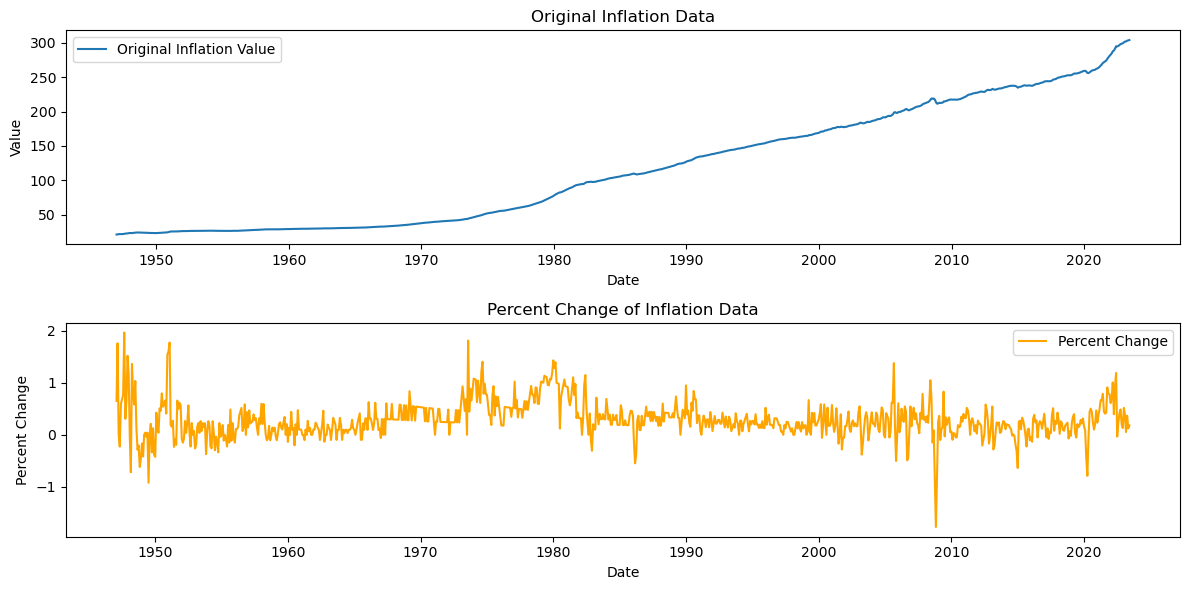

In [109]:
# Ensure 'date' column is set as index
inflation['date'] = pd.to_datetime(inflation['date'], errors='coerce')
inflation.set_index('date', inplace=True)
inflation.sort_index(inplace=True)

# Calculate the percent change
inflation['percent_change'] = inflation['value'].pct_change() * 100

# Plot the original and percent change data
plt.figure(figsize=(12, 6))

# Original Inflation Data
plt.subplot(2, 1, 1)
plt.plot(inflation.index, inflation['value'], label='Original Inflation Value')
plt.title('Original Inflation Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Percent Change Data
plt.subplot(2, 1, 2)
plt.plot(inflation.index, inflation['percent_change'], label='Percent Change', color='orange')
plt.title('Percent Change of Inflation Data')
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.legend()

plt.tight_layout()
plt.show()


### GDP

Index(['DATE', 'GDPC1'], dtype='object')


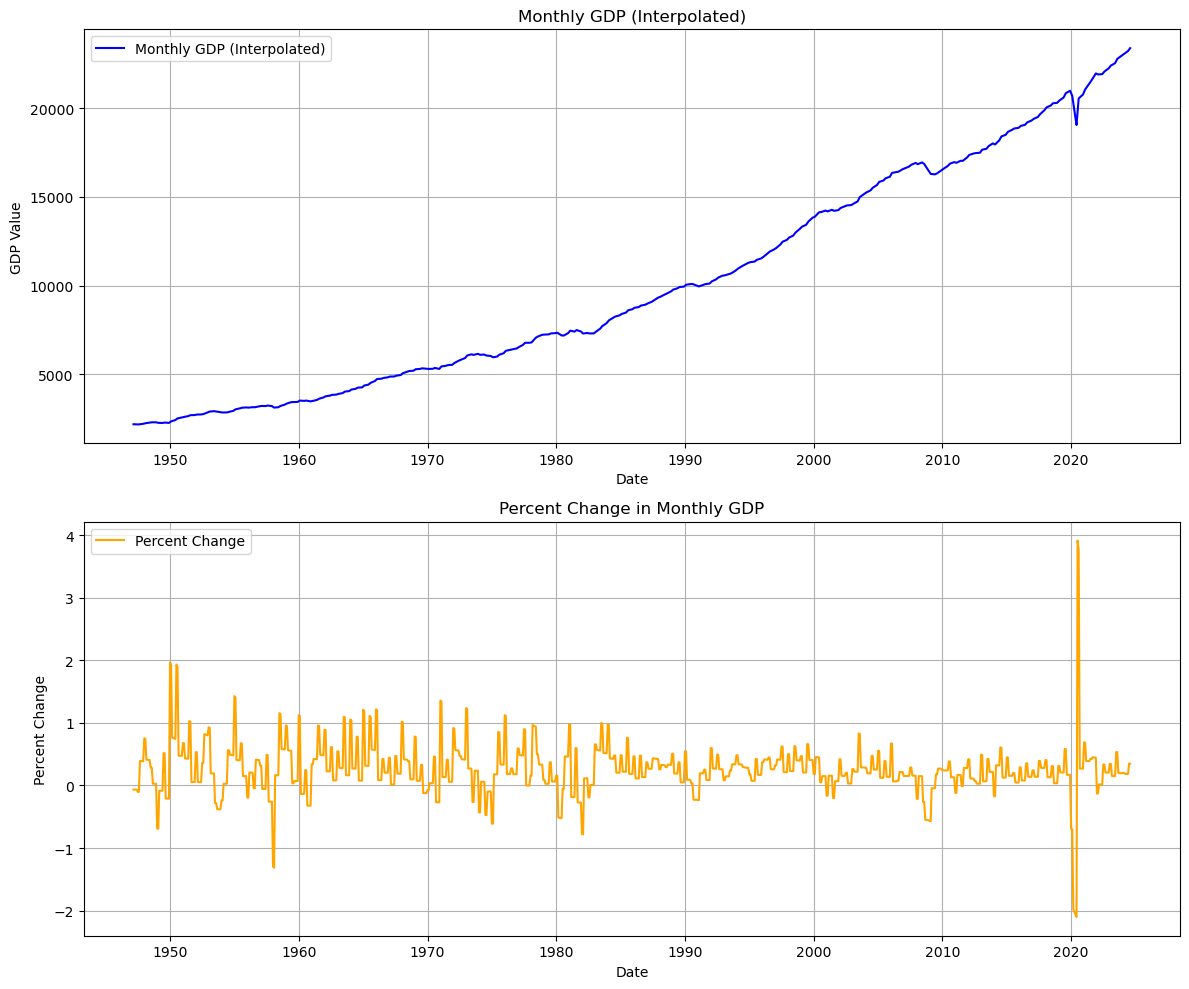

In [110]:
print(gdp.columns)

gdp['DATE'] = pd.to_datetime(gdp['DATE'])
gdp.set_index('DATE', inplace=True)
gdp.sort_index(inplace=True)

# Resample to bimonthly frequency and interpolate
gdp_bimonthly = gdp.resample('2M').mean()
gdp_bimonthly = gdp_bimonthly.interpolate(method='linear')

# Resample to monthly frequency and interpolate
gdp_monthly = gdp_bimonthly.resample('M').mean()
gdp_monthly = gdp_monthly.interpolate(method='linear')

# Calculate percent change
gdp_monthly['percent_change'] = gdp_monthly['GDPC1'].pct_change() * 100

# Drop NaN rows resulting from percent change calculation
gdp_monthly_cleaned = gdp_monthly.dropna()

full_index = pd.date_range(start=gdp.index.min(), end=gdp.index.max(), freq='M')


# Visualization with two separate charts

plt.figure(figsize=(12, 10))

# Chart 1: Monthly GDP
plt.subplot(2, 1, 1)
plt.plot(gdp_monthly_cleaned.index, gdp_monthly_cleaned['GDPC1'], label='Monthly GDP (Interpolated)', color='blue')
plt.title('Monthly GDP (Interpolated)')
plt.xlabel('Date')
plt.ylabel('GDP Value')
plt.legend()
plt.grid(True)

# Chart 2: Percent Change in GDP
plt.subplot(2, 1, 2)
plt.plot(gdp_monthly_cleaned.index, gdp_monthly_cleaned['percent_change'], label='Percent Change', color='orange')
plt.title('Percent Change in Monthly GDP')
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Data Date Range

In [111]:
import pandas as pd

# GDP Dataset
print("GDP Dataset:")
gdp.index = pd.to_datetime(gdp.index, errors='coerce')  # Ensure index is datetime
print("GDP Index Type:", gdp.index.dtype)
print("GDP Date Range:", gdp.index.min(), "to", gdp.index.max())

# Inflation Dataset
print("\nInflation Dataset:")
inflation['date'] = pd.to_datetime(inflation.index, errors='coerce')  # Convert 'date' column to datetime
inflation.set_index('date', inplace=True)  # Set 'date' as index
print("Inflation Index Type:", inflation.index.dtype)
print("Inflation Date Range:", inflation.index.min(), "to", inflation.index.max())

# Unemployment Dataset
print("\nUnemployment Dataset:")
unemployment['date'] = pd.to_datetime(unemployment.index, errors='coerce')  # Convert 'date' column to datetime
unemployment.set_index('date', inplace=True)  # Set 'date' as index
print("Unemployment Index Type:", unemployment.index.dtype)
print("Unemployment Date Range:", unemployment.index.min(), "to", unemployment.index.max())

# Yield Curve Dataset
print("\nYield Curve Dataset:")
yield_data['Date'] = pd.to_datetime(yield_data.index, errors='coerce')  # Convert 'Date' column to datetime
yield_data.set_index('Date', inplace=True)  # Set 'Date' as index
print("Yield Curve Index Type:", yield_data.index.dtype)
print("Yield Curve Date Range:", yield_data.index.min(), "to", yield_data.index.max())


GDP Dataset:
GDP Index Type: datetime64[ns]
GDP Date Range: 1947-01-01 00:00:00 to 2024-07-01 00:00:00

Inflation Dataset:
Inflation Index Type: datetime64[ns]
Inflation Date Range: 1947-01-01 00:00:00 to 2023-06-01 00:00:00

Unemployment Dataset:
Unemployment Index Type: datetime64[ns]
Unemployment Date Range: 1948-01-01 00:00:00 to 2024-05-01 00:00:00

Yield Curve Dataset:
Yield Curve Index Type: datetime64[ns]
Yield Curve Date Range: 1961-06-14 00:00:00 to 2024-11-15 00:00:00
